<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px"></p>

# Intra-day Machine Learning


<br>


📈Join our community: https://discord.gg/wXjNPAc5BH

📚Read our book: https://www.amazon.com/gp/product/B09HG18CYL 

🖥️Quantreo's YouTube channel: https://www.youtube.com/channel/UCp7jckfiEglNf_Gj62VR0pw

In [ ]:
! pip install yfinance
! pip install ta

     |████████████████████████████████| 63 kB 1.2 MB/s 
     |████████████████████████████████| 6.4 MB 14.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28908 sha256=58346526f4cffa6f3883579344ca6237e5eaeba6ef87c5f71fe8669f30491e4f
  Stored in directory: /root/.cache/pip/wheels/72/78/64/cc1c01506a1010a9

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
import ta

In [ ]:
import matplotlib as mpl
from matplotlib import cycler

colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

# Functions

In [ ]:
def lin_reg_trading(symbol):
  def preprocessing_min(name):

    # Import the data
    df = pd.read_csv(name, delimiter="\t", index_col=["<DATE>","<TIME>"] , parse_dates=True).dropna()

    # Delete the two last columns
    df = df.iloc[:,:-2]

    # Rename
    df.columns = ["open", "high", "low", "close", "volume"]
    #df.index.name = "time"
    return df

  def feature_engineering(df):
    """ Create new variables"""
    
    # We copy the dataframe to avoid interferences in the data
    df_copy = df.dropna().copy()
    
    # Create the returns
    df_copy["returns"] = df_copy["close"].pct_change(1)

    # Create the SMAs
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)
    
    # Create the volatilities
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(1)
    
    # Create the Rsi
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window= 14, fillna = False)
    df_copy["rsi"] = RSI.rsi()
    
    return df_copy.dropna()
  

  # Import the data
  df = preprocessing_min(symbol)

  dfc = feature_engineering(df)

  # Percentage train set
  split = int(0.80*len(dfc))

  # Train set creation
  X_train = dfc[['SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi']].iloc[:split]
  y_train = dfc[["returns"]].iloc[:split]


  # Test set creation
  X_test = dfc[['SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi']].iloc[split:]
  y_test = dfc[["returns"]].iloc[split:]

  # Import the class
  from sklearn.linear_model import LinearRegression

  # Initialize the class
  reg = LinearRegression()

  # Fit the model
  reg.fit(X_train, y_train)

  # Create predictions for the whole dataset
  X = np.concatenate((X_train, X_test), axis=0)

  dfc["prediction"] = reg.predict(X)

  # Compute the position
  dfc["position"] = np.sign(dfc["prediction"])

  # Compute the returns
  dfc["strategy"] = dfc["returns"] * dfc["position"].shift(1)


  return dfc["strategy"][dfc["strategy"]<0.50]

# Application

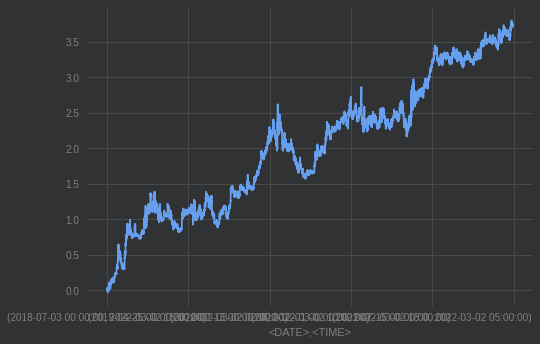

In [ ]:
 lin_reg_trading("ETHUSD_H1.csv").cumsum().plot()

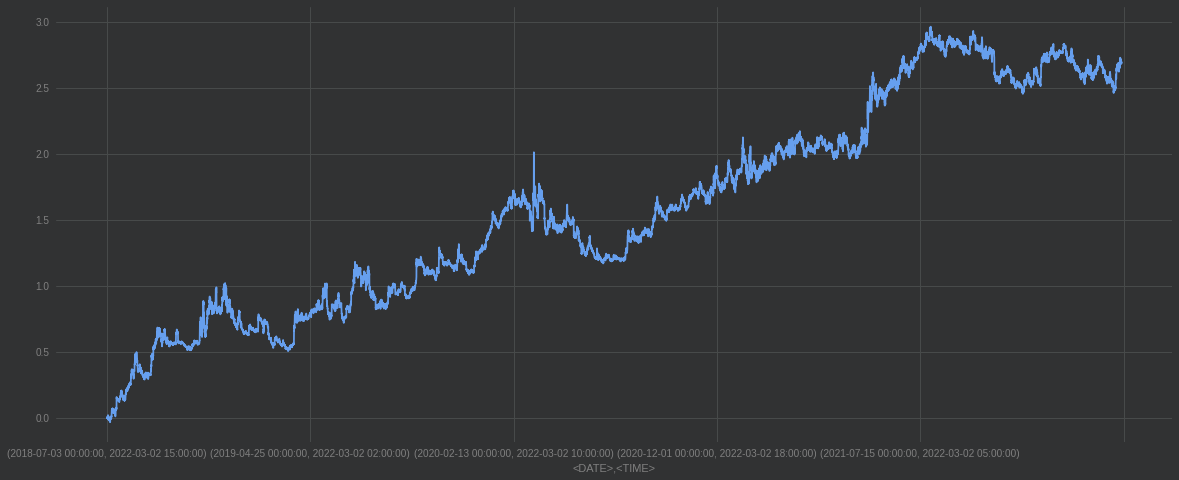

In [ ]:
# List of assets
listnames = ["BTCUSD_H1.csv", "ETHUSD_H1.csv"]
returns = pd.DataFrame()

# Compute the return of each strategy
for name in listnames:
  returns[name] = lin_reg_trading(name)

# Plot the results
(returns.dropna().sum(axis=1)/returns.shape[1]).cumsum().plot(figsize=(20,8))

In [ ]:
pf = returns.dropna().sum(axis=1)/returns.shape[1]

In [ ]:
def drawdown_function(serie):

  # We compute Cumsum of the returns
  cum = serie.dropna().cumsum() + 1

  # We compute max of the cumsum on the period (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
  running_max = np.maximum.accumulate(cum)

  # We compute drawdown
  drawdown = cum/running_max - 1
  return drawdown

In [ ]:
(pf.dropna().cumsum().iloc[-1]) / -np.min(drawdown_function(pf.dropna()))

9.63760692141075